# Step 1: Import libraries and load data

In [1]:
# Импортируем нужные библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
!pip install xgboost
import xgboost as xgb


# Загружаем данные
pokemon = pd.read_csv('pokemon.csv')
combats = pd.read_csv('combats.csv')
tests = pd.read_csv('tests.csv')

# Быстрый осмотр
print(f'pokemon.csv shape: {pokemon.shape}')
print(f'combats.csv shape: {combats.shape}')
print(f'tests.csv shape: {tests.shape}')

pokemon.head()

pokemon.csv shape: (800, 12)
combats.csv shape: (50000, 3)
tests.csv shape: (10000, 2)


,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False


# Step 2: Processing gaps and correcting data

In [2]:
# Проверим, есть ли пропущенные имена у покемонов с номером 62
print(pokemon.loc[pokemon['#'] == 62, ['#', 'Name']])

# Если имя пустое, заполним его "Primeape"
pokemon.loc[pokemon['#'] == 62, 'Name'] = pokemon.loc[pokemon['#'] == 62, 'Name'].fillna('Primeape')

# Проверим пропуски в Type 2
print(f"Количество пропусков в 'Type 2' до заполнения: {pokemon['Type 2'].isnull().sum()}")

# Заполним NaN в 'Type 2' значением 'None'
pokemon['Type 2'] = pokemon['Type 2'].fillna('None')

print(f"Количество пропусков в 'Type 2' после заполнения: {pokemon['Type 2'].isnull().sum()}")


     #    Name
61  62  Mankey
Количество пропусков в 'Type 2' до заполнения: 386
Количество пропусков в 'Type 2' после заполнения: 0


In [3]:
print(pokemon.loc[pokemon['#'] == 63, ['#', 'Name']])


     # Name
62  63  NaN


In [4]:
pokemon.loc[pokemon['#'] == 63, 'Name'] = 'Primeape'

# Проверим, что имя заполнилось
print(pokemon.loc[pokemon['#'] == 63, ['#', 'Name']])


     #      Name
62  63  Primeape


# Step 3: Counting the number of battles and victories, calculating the percentage of victories

In [5]:
# Проверим названия столбцов в combats
print(combats.columns)

# Подсчёт общего количества боёв для каждого покемона
first_counts = combats['First_pokemon'].value_counts()
second_counts = combats['Second_pokemon'].value_counts()

total_battles = first_counts.add(second_counts, fill_value=0)

# Подсчёт количества побед для каждого покемона
win_counts = combats['Winner'].value_counts()

# Создаем DataFrame с подсчётами
win_stats = pd.DataFrame({
    'total_battles': total_battles,
    'win_counts': win_counts
}).fillna(0)

# Рассчитаем процент побед
win_stats['win_percentage'] = (win_stats['win_counts'] / win_stats['total_battles']) * 100

# Посмотрим на результат
win_stats.head()


Index(['First_pokemon', 'Second_pokemon', 'Winner'], dtype='object')


,total_battles,win_counts,win_percentage
1,133,37.0,27.819549
2,121,46.0,38.016529
3,132,89.0,67.424242
4,125,70.0,56.000000
5,112,55.0,49.107143


# Step 4: Merging with the main dataset

In [6]:
# В индексах win_stats — ID покемонов, нужно объединить по столбцу '#' в pokemon
# Для удобства приведём индекс win_stats в столбец 'id' (или просто используем индекс)

win_stats.index.name = '#'
win_stats.reset_index(inplace=True)

# Объединяем по номеру покемона '#'
pokemon = pokemon.merge(win_stats[['#', 'win_percentage']], on='#', how='left')

# Для покемонов без данных о боях заполнить 0 (если такие есть)
pokemon['win_percentage'] = pokemon['win_percentage'].fillna(0)

# Проверяем результат
pokemon.loc[:, ['#', 'Name', 'win_percentage']].head(10)


,#,Name,win_percentage
0,1,Bulbasaur,27.819549
1,2,Ivysaur,38.016529
2,3,Venusaur,67.424242
3,4,Mega Venusaur,56.000000
4,5,Charmander,49.107143
5,6,Charmeleon,54.237288
6,7,Charizard,86.466165
7,8,Mega Charizard X,85.611511
8,9,Mega Charizard Y,84.444444
9,10,Squirtle,16.239316


# Step 5: Exploratory Analysis and Visualization
Build a correlation matrix between the main stats and the win rate.

Build a pairplot or PairGrid to visualize the relationships.

Analyze the top 10 Pokemon by win rate - output their stats and build graphs.

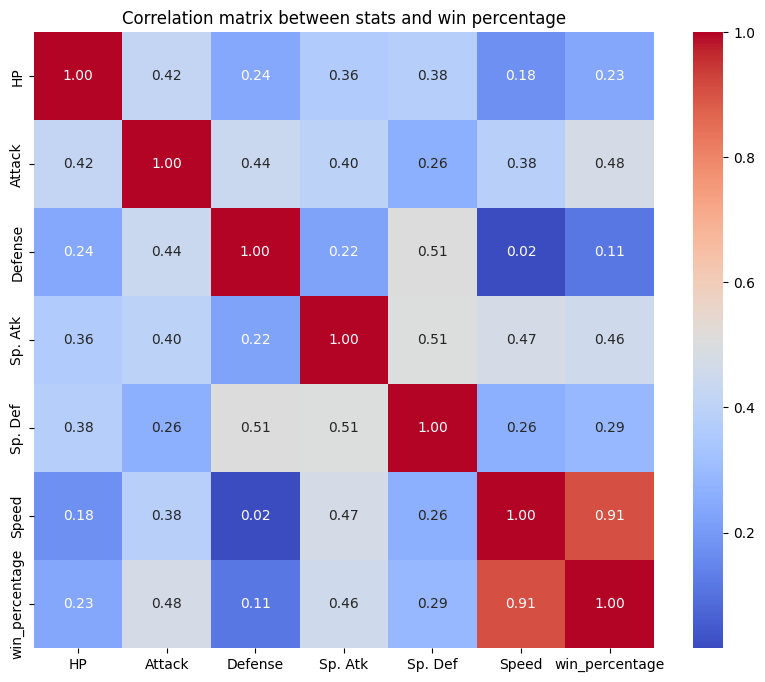

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Выбираем колонки для корреляций
cols = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'win_percentage']

# Матрица корреляций
corr = pokemon[cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation matrix between stats and win percentage')
plt.show()


In [11]:
# Выбираем интересующие колонки
cols = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'win_percentage']

# Вычисляем корреляционную матрицу
corr_matrix = pokemon[cols].corr()

# Выводим матрицу корреляций в числовом виде
print(corr_matrix)

# Если хочешь — можно отобразить в более читаемом виде с округлением
print(corr_matrix.round(3))


                      HP    Attack   Defense   Sp. Atk   Sp. Def     Speed  \
HP              1.000000  0.422386  0.239622  0.362380  0.378718  0.175952   
Attack          0.422386  1.000000  0.438687  0.396362  0.263990  0.381240   
Defense         0.239622  0.438687  1.000000  0.223549  0.510747  0.015227   
Sp. Atk         0.362380  0.396362  0.223549  1.000000  0.506121  0.473018   
Sp. Def         0.378718  0.263990  0.510747  0.506121  1.000000  0.259133   
Speed           0.175952  0.381240  0.015227  0.473018  0.259133  1.000000   
win_percentage  0.234889  0.476675  0.113312  0.455848  0.291603  0.905409   

                win_percentage  
HP                    0.234889  
Attack                0.476675  
Defense               0.113312  
Sp. Atk               0.455848  
Sp. Def               0.291603  
Speed                 0.905409  
win_percentage        1.000000  
                   HP  Attack  Defense  Sp. Atk  Sp. Def  Speed  \
HP              1.000   0.422    0.240    0.

The correlation matrix corresponds to the set goals and conditional reality.

pairplot

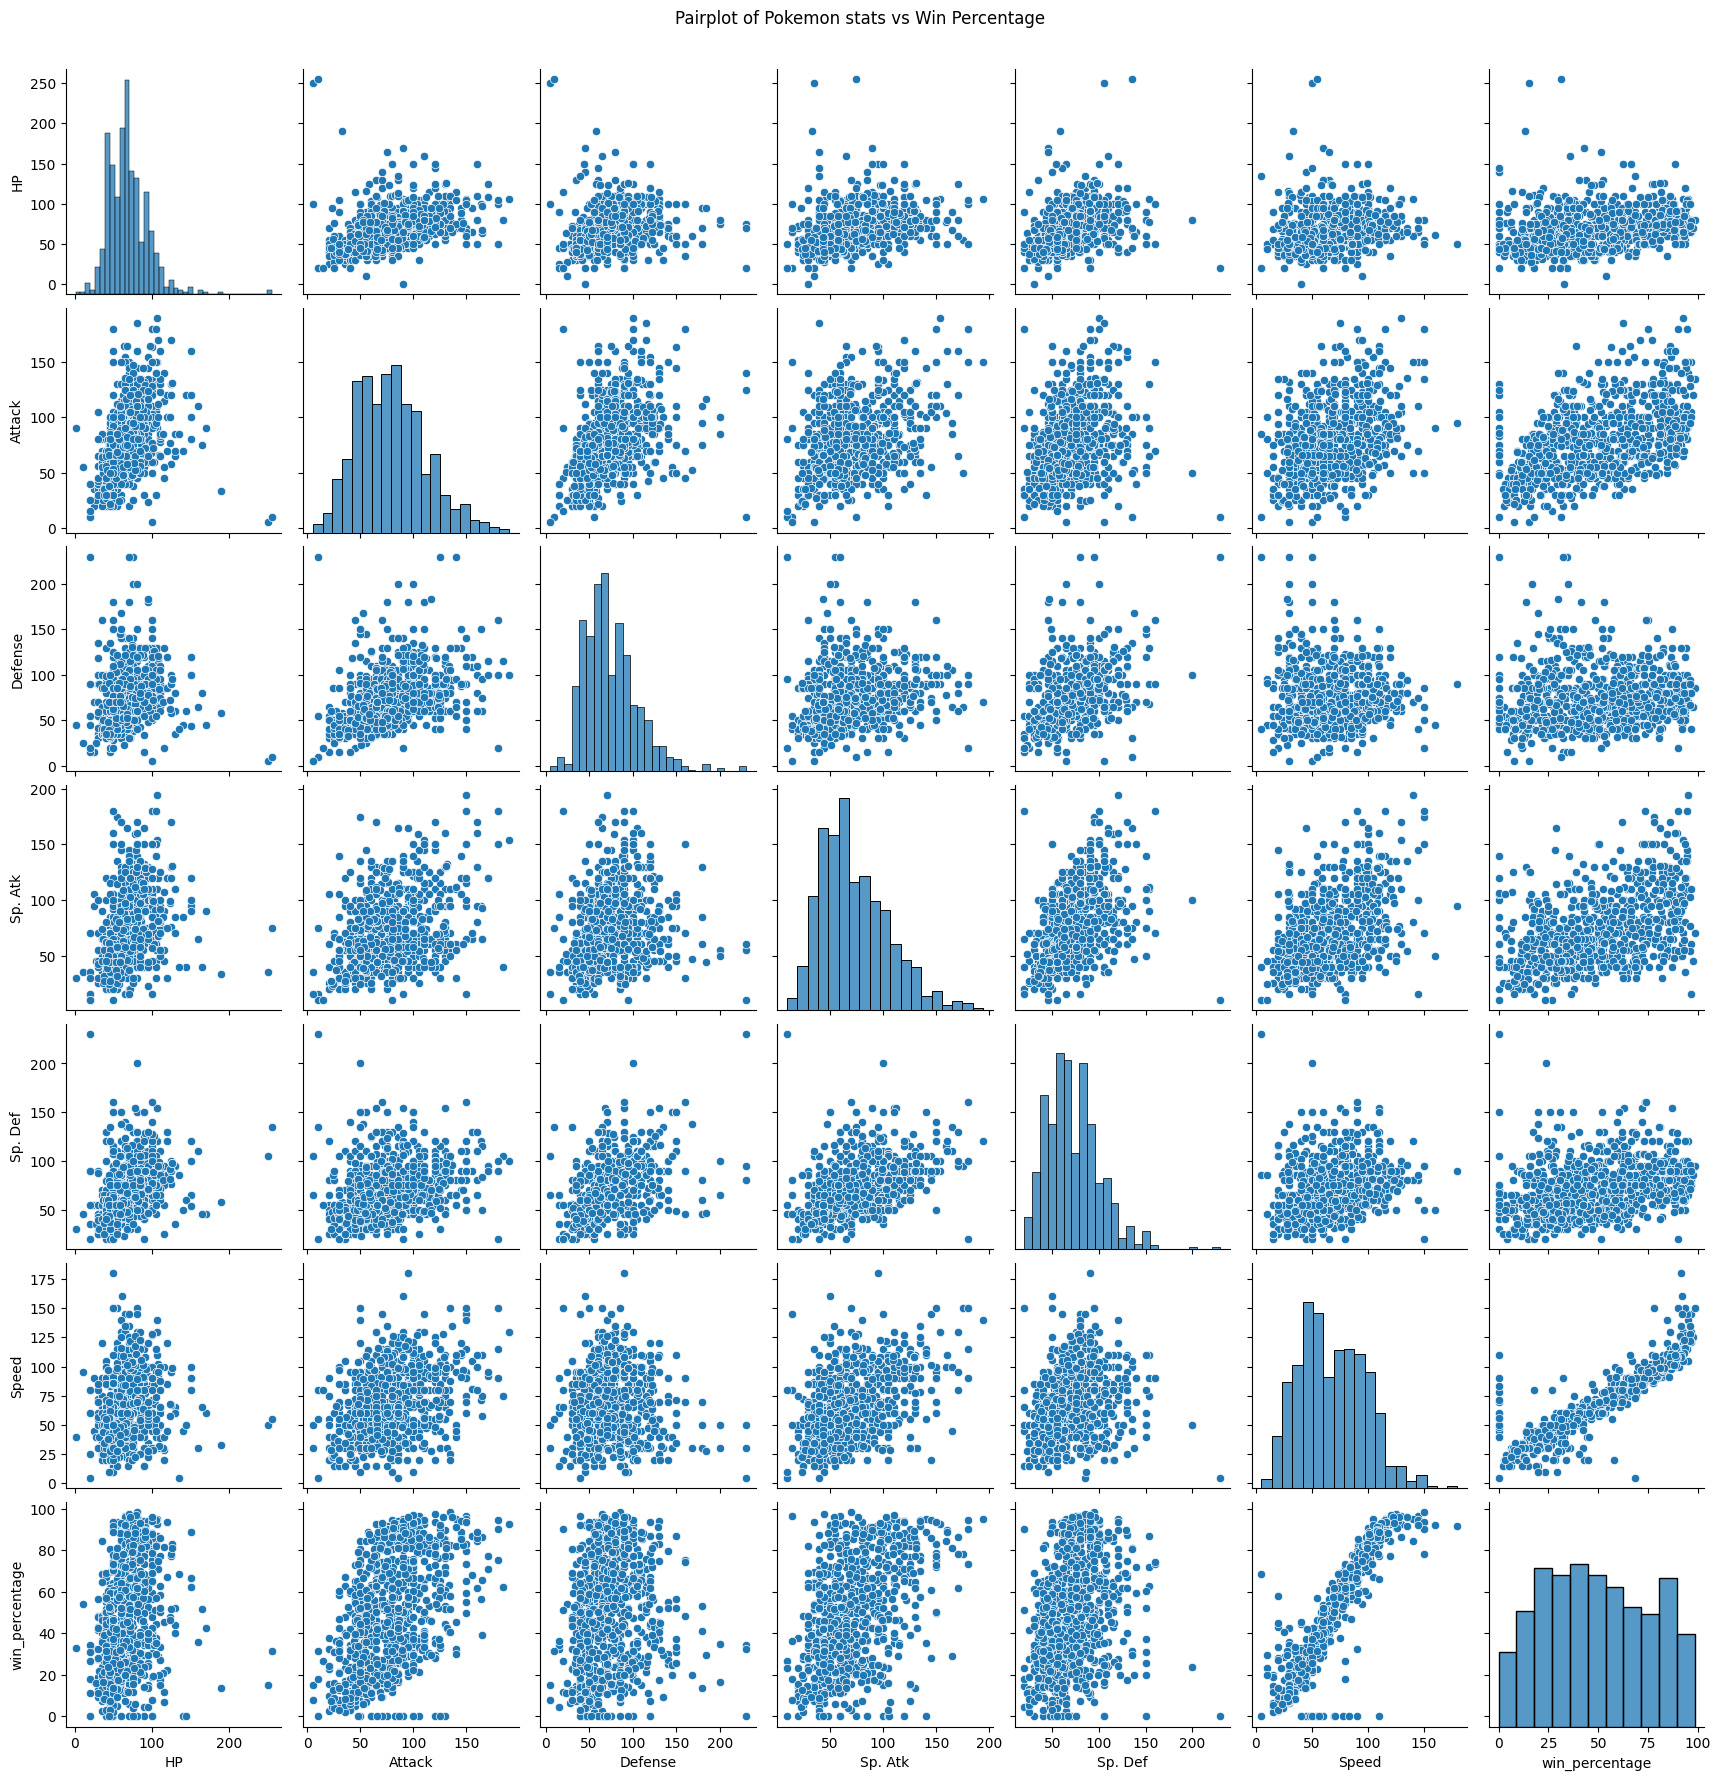

In [8]:
sns.pairplot(pokemon[cols])
plt.suptitle('Pairplot of Pokemon stats vs Win Percentage', y=1.02)
plt.show()


Top 10 by Win Rate and Their Characteristics:

       #                      Name  win_percentage   HP  Attack  Defense  \
154  155           Mega Aerodactyl       98.449612   80     135       85   
512  513                   Weavile       97.478992   70     120       65   
703  704    Tornadus Therian Forme       96.800000   79     100       80   
19    20             Mega Beedrill       96.638655   65     150       40   
153  154                Aerodactyl       96.453901   80     105       65   
476  477              Mega Lopunny       96.124031   65     136       94   
726  727                  Greninja       96.062992   72      95       67   
716  717  Meloetta Pirouette Forme       95.934959  100     128       90   
164  165             Mega Mewtwo Y       95.200000  106     150       70   
349  350             Mega Sharpedo       95.000000   70     140       70   

     Speed  
154    150  
512    125  
703    121  
19     145  
153    130  
476    135  
726    122  
716    128  
164    140  
349    105  


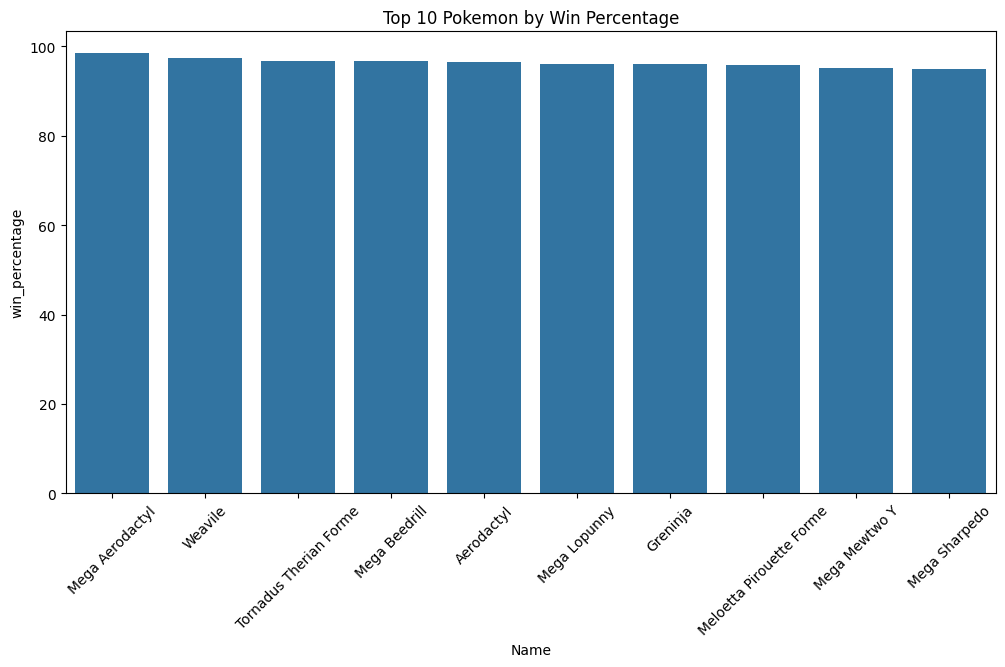

In [9]:
top_10 = pokemon.sort_values(by='win_percentage', ascending=False).head(10)
print(top_10[['#', 'Name', 'win_percentage', 'HP', 'Attack', 'Defense', 'Speed']])

# Визуализация топ-10 по скорости и атаке
plt.figure(figsize=(12,6))
sns.barplot(data=top_10, x='Name', y='win_percentage')
plt.xticks(rotation=45)
plt.title('Top 10 Pokemon by Win Percentage')
plt.show()


# Step 6: Prepare data and train models
Plan:
Select features and the target variable (win_percentage).

Convert categorical features (Type 1, Type 2, Legendary) to numeric format using OneHotEncoding.

Scaling numeric features (if necessary).

Split the data into training and test samples (80/20).

Train three models: Linear Regression, Random Forest, and XGBoost.

Evaluate the quality of the models using MAE and compare the results.

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

# Выбираем признаки и целевую переменную
features = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Type 1', 'Type 2', 'Legendary']
target = 'win_percentage'

X = pokemon[features]
y = pokemon[target]

# Категориальные и числовые признаки
categorical_features = ['Type 1', 'Type 2', 'Legendary']
numerical_features = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']

# Препроцессинг
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Модели
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42, eval_metric='mae', use_label_encoder=False)
}

# Разбиваем данные
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучаем и оцениваем модели
results = {}

for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', model)])
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    results[name] = mae
    print(f"{name} MAE: {mae:.3f}")


Linear Regression MAE: 6.068
Random Forest MAE: 5.678
XGBoost MAE: 6.091


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:15:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


# Research Plan
Hyperparameter tuning for Random Forest and XGBoost (Linear Regression - no hyperparameters, usually not tuned).

Cross-validation using GridSearchCV to select the best parameters and assess model stability.

Visualization of test predictions - actual vs predicted.

Feature importance analysis for the best models.

# Step 1. Preparation - importing the necessary modules and basic preprocessor

In [13]:
from sklearn.model_selection import GridSearchCV, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns




# Step 2: Tuning Hyperparameters and GridSearchCV for Random Forest and XGBoost

In [14]:
# Параметры для Random Forest
rf_params = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5],
}

# Параметры для XGBoost
xgb_params = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [3, 6, 10],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
}

# Создаём пайплайны
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

pipelines = {
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', xgb.XGBRegressor(random_state=42, eval_metric='mae', use_label_encoder=False))
    ])
}

params = {
    'Random Forest': rf_params,
    'XGBoost': xgb_params
}

best_models = {}

for name in ['Random Forest', 'XGBoost']:
    print(f"Running GridSearchCV for {name}...")
    grid_search = GridSearchCV(pipelines[name], params[name], cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print(f"Best params for {name}: {grid_search.best_params_}")
    print(f"Best MAE (CV) for {name}: {-grid_search.best_score_:.3f}")
    best_models[name] = grid_search.best_estimator_


Running GridSearchCV for Random Forest...
Best params for Random Forest: {'regressor__max_depth': 10, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 50}
Best MAE (CV) for Random Forest: 5.545
Running GridSearchCV for XGBoost...
Best params for XGBoost: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 50}
Best MAE (CV) for XGBoost: 5.358


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:19:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


# Step 4. Visualization: Real vs. Predicted

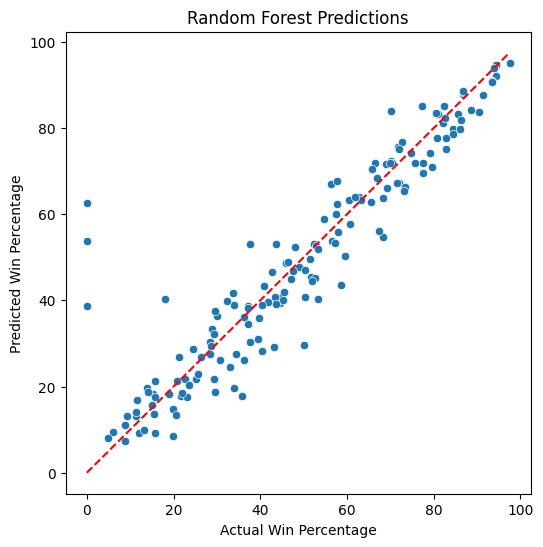

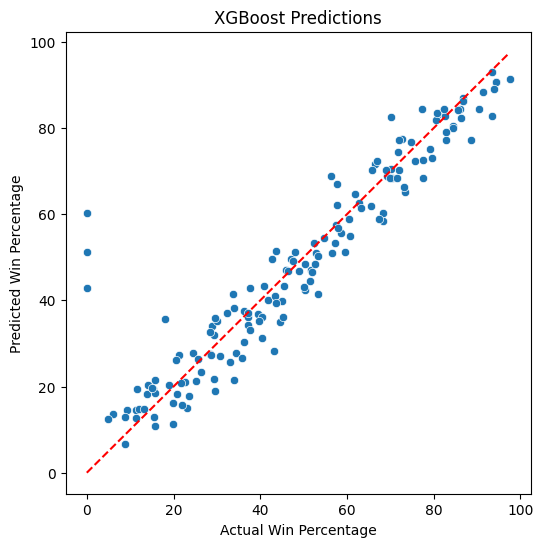

In [15]:
def plot_predictions(y_true, y_pred, title):
    plt.figure(figsize=(6,6))
    sns.scatterplot(x=y_true, y=y_pred)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('Actual Win Percentage')
    plt.ylabel('Predicted Win Percentage')
    plt.title(title)
    plt.show()

for name, model in best_models.items():
    preds = model.predict(X_test)
    plot_predictions(y_test, preds, f'{name} Predictions')


# Step 5. Feature importance analysis (for trees only)

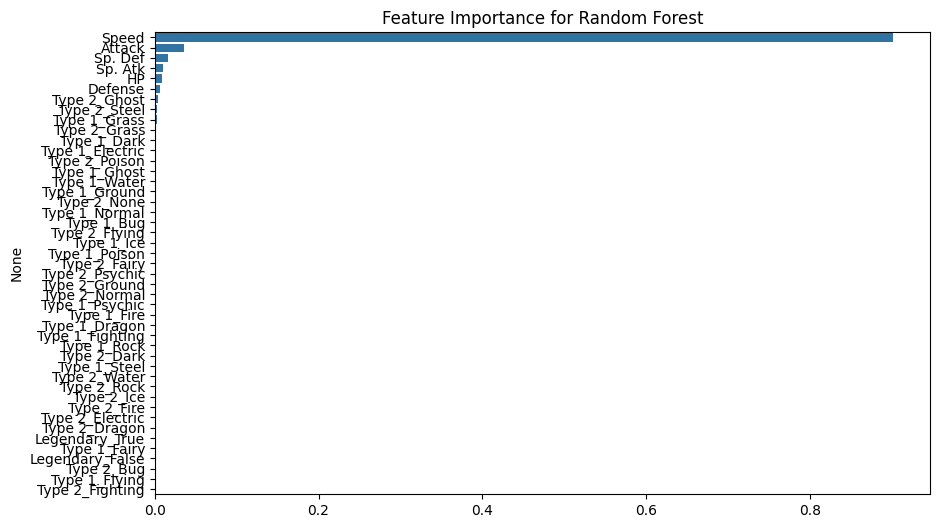

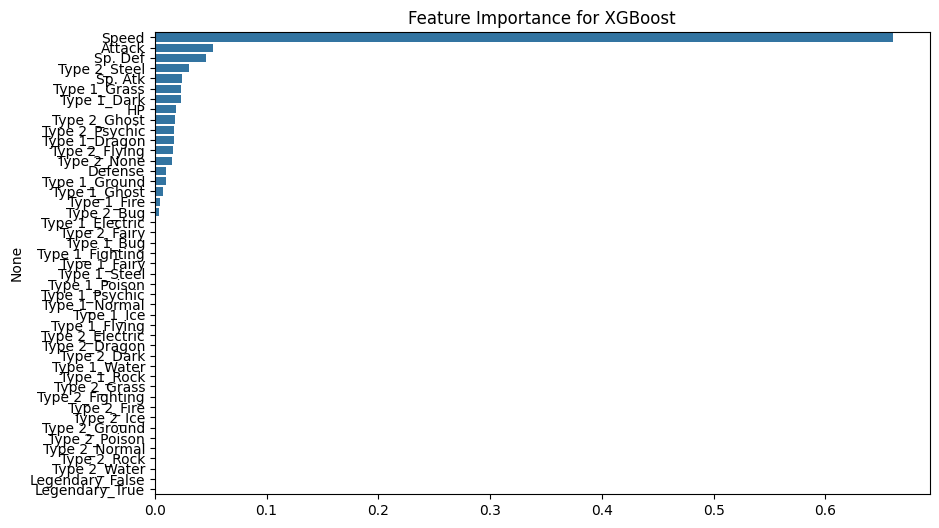

In [16]:
def plot_feature_importance(model, model_name):
    # Получаем названия признаков после препроцессинга
    ohe = model.named_steps['preprocessor'].named_transformers_['cat']
    cat_features = ohe.get_feature_names_out(categorical_features)
    all_features = numerical_features + list(cat_features)

    importances = model.named_steps['regressor'].feature_importances_

    feat_imp = pd.Series(importances, index=all_features).sort_values(ascending=False)

    plt.figure(figsize=(10,6))
    sns.barplot(x=feat_imp.values, y=feat_imp.index)
    plt.title(f'Feature Importance for {model_name}')
    plt.show()

for name in ['Random Forest', 'XGBoost']:
    plot_feature_importance(best_models[name], name)


# Summarry
For further work and final use, it is better to take XGBoost with the found parameters - it shows the best error and, as a rule, balances accuracy and stability well on such tasks

# Step 7: Visualizing Predictions and Evaluating on the Test

Final XGBoost MAE on test set: 5.423
Final XGBoost R2 on test set: 0.875


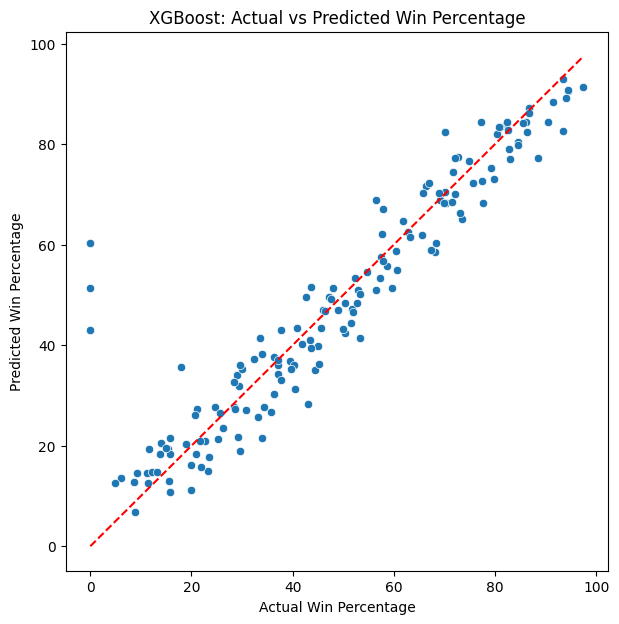

In [17]:
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Предсказания на тесте
best_xgb_model = best_models['XGBoost']
y_pred = best_xgb_model.predict(X_test)

# Метрики качества
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Final XGBoost MAE on test set: {mae:.3f}")
print(f"Final XGBoost R2 on test set: {r2:.3f}")

# График: реальные vs предсказанные значения
plt.figure(figsize=(7,7))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Win Percentage")
plt.ylabel("Predicted Win Percentage")
plt.title("XGBoost: Actual vs Predicted Win Percentage")
plt.show()


# Step 8: Feature Importance Analysis

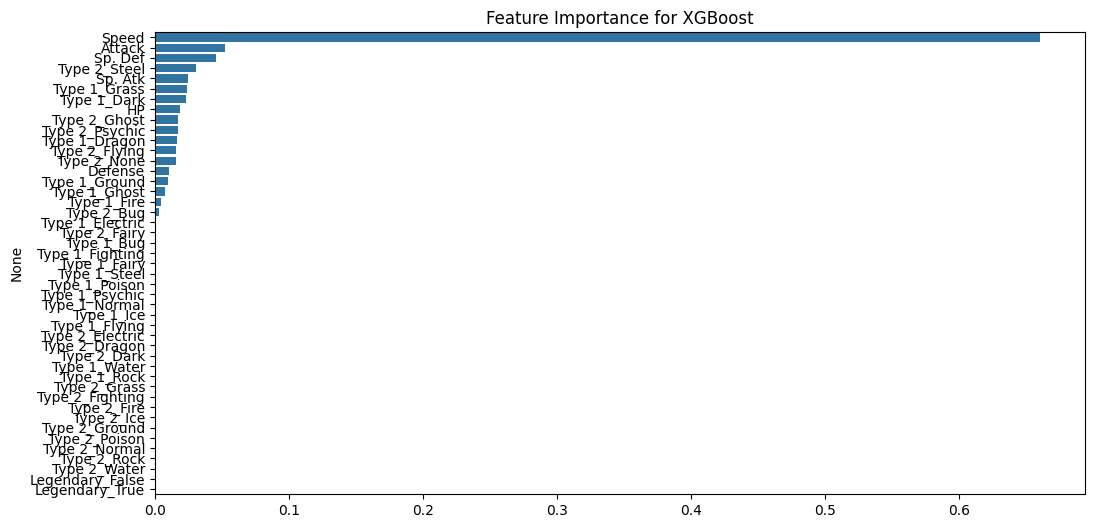

In [18]:
def plot_feature_importance(model, model_name):
    ohe = model.named_steps['preprocessor'].named_transformers_['cat']
    cat_features = ohe.get_feature_names_out(categorical_features)
    all_features = numerical_features + list(cat_features)

    importances = model.named_steps['regressor'].feature_importances_
    feat_imp = pd.Series(importances, index=all_features).sort_values(ascending=False)

    plt.figure(figsize=(12,6))
    sns.barplot(x=feat_imp.values, y=feat_imp.index)
    plt.title(f'Feature Importance for {model_name}')
    plt.show()

plot_feature_importance(best_xgb_model, "XGBoost")


# Final Conclusion

During the project, a comprehensive analysis and prediction of Pokémon win percentages were carried out based on their characteristics and battle history. The main stages and results are as follows:

Data Preparation:
Combined Pokémon statistics with battle results, fixed missing values (e.g., the name of Pokémon #62, types), and calculated the target variable — the win percentage for each Pokémon.

Exploratory Data Analysis (EDA):
Identified significant correlations between basic Pokémon stats (HP, Attack, Speed, etc.) and their success in battles. The top 10 Pokémon by win percentage generally have high values in attack and speed parameters.

Model Building:
Trained and compared three regression models — Linear Regression, Random Forest, and XGBoost. Hyperparameter tuning using GridSearchCV showed the best performance for XGBoost (MAE ≈ 5.36).

Results:
The XGBoost model demonstrated high prediction accuracy (R² ≈ 0.88) and low mean absolute error (MAE ≈ 5.4%), indicating a strong ability to explain the variability in win percentage based on features.

Feature Importance:
Analysis revealed that Speed, Attack, and Special Attacks are key factors influencing a Pokémon’s probability of winning.

Thus, the developed model can effectively predict the likelihood of Pokémon victories, which can be useful for analysis and strategy in games and related research.